# Selecting the best borough in London for immigrant family
__by Ismayil Jabiyev 2019__

## Introduction/Business Problem

London is the largest city and business capital of the UK and considered to be one of the world's most important global cities that is most investment friendly and most popular for work. This results in a great inflow of different labor force including domestic immigration to the city. According to Oxford University's Migration Observatory report, in 2017 3,354,000 people or 36% of the city's population were foreign born.

As a person planning to permanently settle down in London the question is what is the best place to settle down, especially if he is coming with a family and children. One of the most crucial question is what is the best adequate place considering a number of variables as cost of living, crime rate, ecology and situation with education and how London boroughs looks like in terms of attractiveness to a family with kids.

## Data retrieval

A number of publicly available data sets for London boroughs will be used. This include https://data.london.gov.uk/ datasets of:

Crime rate (number of offences)
Average rent prices
Environmental footprint (measured by carbon emissions)
Number of 2-bedroom apartments (the more is better)
Number of parks
Number of schools
Traffic intensity

## Methodology

The London boroughs are the 32 local authority districts that make up the Greater London county. Each borough will be assigned with a set of normalized parameters as per data above. With the help of Foursquare I will extract additional data as number of parks that will add additional parameters to assess attractiveness for a family.

Boroughs will be visualized on the map. A formula will calculate the score of family friendliness basing on the normalized parameters above. No weights will be applied. Basing on the results most family friendly boroughs will be selected and advised.

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2019.3.9           |           py36_0         149 KB  conda-forge
    conda-4.6.8                |           py36_0         876 KB  conda-forge
    openssl-1.1.1b             |       h14c3975_1         4.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following packages will be UPDATED:

  ca-certificates                     2018.11.29-ha4d7672_0 --> 2019.3.9-hecc5488_0
  certifi                              2018.11.29-py36_1000 --> 2019.3.9-py36_0
  conda                                        4.6.4-py36_0 --> 4.6

In [2]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import folium
import os
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import json
%matplotlib inline
print('done')

done


After the important packages have been imported, lets run a beautiful soup, parse the Wikipedia article into dataframe, and make data wrangling to make an easy table with clear names of London boroughs, basic widipedia data and coordinates.

In [3]:
link = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
page = urlopen(link)
soup = BeautifulSoup(page, 'html.parser')
Table = soup.find('table', {"class":"wikitable sortable"})
List = Table.find_all('td')
# next step would be to strip the <td> tags and create a list of clear London borough names and data.
inputs=[]
for td_tag in List:
    inputs.append(td_tag.text)
inputs = list(map(lambda x:x.strip(),inputs))
London = pd.DataFrame(np.array(inputs).reshape(32,10), 
                      columns = ['Borough', '2', '3', '4', '5','Headquarters','Area','Population','Coordinates','10'])
# we will drop unneseccary columns
London.drop(columns=['2','3','4','5','10'], inplace=True)
London2 = London.Coordinates.str.split("/", expand=True)
London2.drop(London2.columns[0:2],axis=1,inplace=True)
London2.columns = ['Coordinates']
London3 = London2.Coordinates.str.split(" ", expand=True)
London3.drop(London2.columns[3:4],axis=1,inplace=True)
Latitude = London3[1].str.strip(';\ufeff')
Longitude = London3[2].str.strip(';\ufeff')
# Creating new columns in existing London dataframe and coverting the coordinates into floats
London['Latitude'] = Latitude
London['Longitude'] = Longitude
London['Latitude'] = London.Latitude.astype(float)
London['Longitude'] = London.Longitude.astype(float)
# Converting the Population numbers to float as well
London['Population'] = London['Population'].str.replace(',','')
London['Population'] = London.Population.astype(float)
# Adjusting some borough names and removing unnessary notations and dropping not needed coordinates
London.iloc[0,0] = 'Barking and Dagenham'
London.iloc[9,0] = 'Greenwich'
London.iloc[11,0] = 'Hammersmith and Fulham'
London.drop(columns=['Coordinates'], inplace=True)
London.head()

,Borough,Headquarters,Area,Population,Latitude,Longitude
0,Barking and Dagenham,"Town Hall, 1 Town Square",13.93,194352.0,51.5607,0.1557
1,Barnet,"North London Business Park, Oakleigh Road South",33.49,369088.0,51.6252,-0.1517
2,Bexley,"Civic Offices, 2 Watling Street",23.38,236687.0,51.4549,0.1505
3,Brent,"Brent Civic Centre, Engineers Way",16.70,317264.0,51.5588,-0.2817
4,Bromley,"Civic Centre, Stockwell Close",57.97,317899.0,51.4039,0.0198


Next step is to utilize the Foursquare API to extract number of parks

In [4]:
import requests
CLIENT_ID = 'W5ECZEABWIWO1JBGQZNDSDEA4AY4GHEXJ4QPMSNPVCLES5YG' # your Foursquare ID
CLIENT_SECRET = 'REAQNTOZIKMAJW5I3DZ3O45IQSNYXV4ISSMYLM0VSNS3UDQ3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W5ECZEABWIWO1JBGQZNDSDEA4AY4GHEXJ4QPMSNPVCLES5YG
CLIENT_SECRET:REAQNTOZIKMAJW5I3DZ3O45IQSNYXV4ISSMYLM0VSNS3UDQ3


In [5]:
def NumberofVenues(latitude, longitude, category):
    radius = 1000
    LIMIT = 100
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT,
            category)
            
    # make the GET request
    response = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue

    return(len(response))

In [7]:
category = '4bf58dd8d48988d163941735' #this is a park category
for index, row in London.iterrows():
    lat = London.loc[index, 'Latitude']
    lng = London.loc[index, 'Longitude']
    London.loc[index,'Parks'] = NumberofVenues(lat,lng,category)
London.head()

,Borough,Headquarters,Area,Population,Latitude,Longitude,Parks
0,Barking and Dagenham,"Town Hall, 1 Town Square",13.93,194352.0,51.5607,0.1557,2.0
1,Barnet,"North London Business Park, Oakleigh Road South",33.49,369088.0,51.6252,-0.1517,3.0
2,Bexley,"Civic Offices, 2 Watling Street",23.38,236687.0,51.4549,0.1505,1.0
3,Brent,"Brent Civic Centre, Engineers Way",16.70,317264.0,51.5588,-0.2817,2.0
4,Bromley,"Civic Centre, Stockwell Close",57.97,317899.0,51.4039,0.0198,7.0


Now having the coordinates and numbers of parks using the Foursquare, I can add up available public statistical data to complement my choice. In the project statement I mentioned that apart presence of parks to walk with my family, I highlighted important economic parameters as availability of accessible housing (number of 2 bed apartment considering familty with 1-2 children and average price of rent per borough), traffic intensity, pollution (as I could not find exact air pollution stats per borough, I will use carbon emission per borough as an estimate) and crime rate (number of offences) and number of all schools.

All the data was public available at London Datastore https://data.london.gov.uk/ and the rent price from statista.com for July 2018. As number of boroughs is not that large, I found it easier to dowload and compile the data in csv format without a need to run it through a code. Let's access to this csv and append the existing London dataframe with additional data. Using IBM internal command, I add csv to the notebook and import it as dataframe

In [8]:
df_data_1 = pd.read_csv('Londondata.csv')
London['Offences'] = df_data_1['Offences'].astype(float)
London['Apartments'] = df_data_1['Apartments'].astype(float)
London['Emissions'] = df_data_1['Emissions'].astype(float)
London['Traffic'] = df_data_1['Traffic'].astype(float)
London['Rent'] = df_data_1['Rent'].astype(float)
London['Schools'] = df_data_1['Schools'].astype(float)
London.dtypes

Borough          object
Headquarters     object
Area             object
Population      float64
Latitude        float64
Longitude       float64
Parks           float64
Offences        float64
Apartments      float64
Emissions       float64
Traffic         float64
Rent            float64
Schools         float64
dtype: object

In [9]:
London.head()

,Borough,Headquarters,Area,Population,Latitude,Longitude,Parks,Offences,Apartments,Emissions,Traffic,Rent,Schools
0,Barking and Dagenham,"Town Hall, 1 Town Square",13.93,194352.0,51.5607,0.1557,2.0,14638.0,27710.0,644.0,599.0,1209.0,64.0
1,Barnet,"North London Business Park, Oakleigh Road South",33.49,369088.0,51.6252,-0.1517,3.0,21549.0,42260.0,1415.0,1657.0,1528.0,163.0
2,Bexley,"Civic Offices, 2 Watling Street",23.38,236687.0,51.4549,0.1505,1.0,11163.0,26710.0,975.0,917.0,1282.0,84.0
3,Brent,"Brent Civic Centre, Engineers Way",16.70,317264.0,51.5588,-0.2817,2.0,23237.0,33750.0,1175.0,854.0,1548.0,103.0
4,Bromley,"Civic Centre, Stockwell Close",57.97,317899.0,51.4039,0.0198,7.0,17243.0,37830.0,1180.0,1217.0,1345.0,121.0


Second part is visualization of the data and analysis

In [10]:
import folium
london_map = folium.Map(location=[51.50853, -0.12574], zoom_start=8, tiles='Mapbox Bright')

Next step is to create a borough marks on the map

In [21]:
address = 'London'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_london = folium.Map(location=[latitude, longitude], zoom_start=10, height = '70%', width = '70%')

# add markers to map
for lat, lng, borough in zip(London['Latitude'], London['Longitude'], London['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  

map_london

The main study question is how friendly is the borough for the family with a kid moving to London. We have a number of various parameters set up in the dataframe. The suggested methodology is to assign a score to each borough taking into consideration the average of all parameters. Let's consider each paratemer is equally weighted, so score would be the following:

Family friendliness = Schools + Parks + Apartments - Emissions - Traffic - Offences - Rent

Considering all paratemers are equally important, and taking into consideration the great span of data, we will normalize the all values.

In [49]:
London.columns[6:13]

Index(['Parks', 'Offences', 'Apartments', 'Emissions', 'Traffic', 'Rent',
       'Schools'],
      dtype='object')

In [12]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(London.loc[:,'Parks':'Schools'])
London_norm = pd.DataFrame(np_scaled)
London_norm['Borough'] = London['Borough']
London_norm.columns = ['Parks', 'Offences', 'Apartments', 'Emissions', 'Traffic', 'Rent', 'Schools','Borough']
London_norm.head()

,Parks,Offences,Apartments,Emissions,Traffic,Rent,Schools,Borough
0,0.033333,0.175174,0.311592,0.000000,0.119653,0.106591,0.000000,Barking and Dagenham
1,0.066667,0.380401,0.781401,0.414962,0.731214,0.366151,1.000000,Barnet
2,0.000000,0.071982,0.279303,0.178149,0.303468,0.165989,0.202020,Bexley
3,0.033333,0.430527,0.506619,0.285791,0.267052,0.382425,0.393939,Brent
4,0.200000,0.252532,0.638360,0.288482,0.476879,0.217250,0.575758,Bromley


In [13]:
London_norm['Score'] = London_norm['Parks']-London_norm['Offences']+London_norm['Apartments']-London_norm['Emissions']-London_norm['Traffic']-London_norm['Rent']+London_norm['Schools']

In [14]:
London_norm.head()

,Parks,Offences,Apartments,Emissions,Traffic,Rent,Schools,Borough,Score
0,0.033333,0.175174,0.311592,0.000000,0.119653,0.106591,0.000000,Barking and Dagenham,-0.056493
1,0.066667,0.380401,0.781401,0.414962,0.731214,0.366151,1.000000,Barnet,-0.044660
2,0.000000,0.071982,0.279303,0.178149,0.303468,0.165989,0.202020,Bexley,-0.238265
3,0.033333,0.430527,0.506619,0.285791,0.267052,0.382425,0.393939,Brent,-0.431903
4,0.200000,0.252532,0.638360,0.288482,0.476879,0.217250,0.575758,Bromley,0.178975


In [15]:
London2 = London
London2['Score'] = London_norm['Score']
London2.head()

,Borough,Headquarters,Area,Population,Latitude,Longitude,Parks,Offences,Apartments,Emissions,Traffic,Rent,Schools,Score
0,Barking and Dagenham,"Town Hall, 1 Town Square",13.93,194352.0,51.5607,0.1557,2.0,14638.0,27710.0,644.0,599.0,1209.0,64.0,-0.056493
1,Barnet,"North London Business Park, Oakleigh Road South",33.49,369088.0,51.6252,-0.1517,3.0,21549.0,42260.0,1415.0,1657.0,1528.0,163.0,-0.044660
2,Bexley,"Civic Offices, 2 Watling Street",23.38,236687.0,51.4549,0.1505,1.0,11163.0,26710.0,975.0,917.0,1282.0,84.0,-0.238265
3,Brent,"Brent Civic Centre, Engineers Way",16.70,317264.0,51.5588,-0.2817,2.0,23237.0,33750.0,1175.0,854.0,1548.0,103.0,-0.431903
4,Bromley,"Civic Centre, Stockwell Close",57.97,317899.0,51.4039,0.0198,7.0,17243.0,37830.0,1180.0,1217.0,1345.0,121.0,0.178975


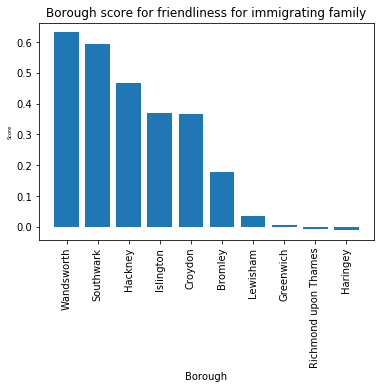

<Figure size 7200x3600 with 0 Axes>

In [16]:
Londongraph = London2.sort_values(['Score'], axis=0, ascending=False).head(10)
result = Londongraph['Score']
label = Londongraph['Borough']
index = np.arange(len(label))
plt.bar(index, result)
plt.xlabel('Borough', fontsize=10)
plt.ylabel('Score', fontsize=5)
plt.xticks(index, label, fontsize=10, rotation=90)
plt.title('Borough score for friendliness for immigrating family')
plt.figure(figsize=(100,50))
plt.show()

We can see that in general Wandsworth is an absolute winner. Following top 10 best candidate are provided.

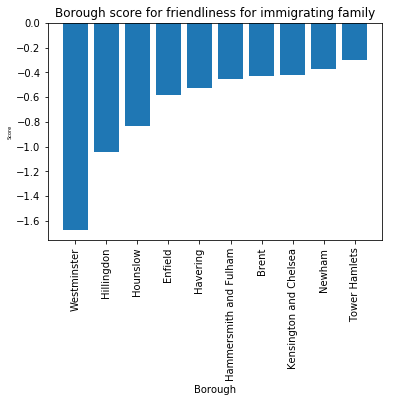

<Figure size 7200x3600 with 0 Axes>

In [17]:
Londongraph2 = London2.sort_values(['Score'], axis=0, ascending=True).head(10)
result = Londongraph2['Score']
label = Londongraph2['Borough']
index = np.arange(len(label))
plt.bar(index, result)
plt.xlabel('Borough', fontsize=10)
plt.ylabel('Score', fontsize=5)
plt.xticks(index, label, fontsize=10, rotation=90)
plt.title('Borough score for friendliness for immigrating family')
plt.figure(figsize=(100,50))
plt.show()

The worst with the lowest score is Westminster

In [20]:
London2.to_csv('London2.csv')